## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


Stakeholders:
Homeowners in the King County area

Our Recommendations will provide: 
Homeowners with guidance on home renovation projects (e.g. converting half bath to full bath or adding garage/patio) that could potentially enhance the value of their homes and estimate the average increase in sales price.

In [1]:
# Import tools and libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.graphics.regressionplots as smg
from statsmodels.formula.api import ols
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.graphics import regressionplots
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit, KFold, cross_val_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from statsmodels.tools.eval_measures import rmse

sns.set(font_scale = 1)

In [2]:
# Import main dataset as dataframe

df = pd.read_csv('data/kc_house_data.csv')

# BEGIN DATA CLEANING

In [3]:
# Check initial datasframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

In [4]:
# Clean data by dropping columns deemed unncessary
# We are only keeping our target variable (price) and variables that the homeowner can easily control/change

df_model = df[['price', 'bedrooms', 'bathrooms', 'grade', 'sqft_garage', 'sqft_patio']]

In [5]:
df_model

,price,bedrooms,bathrooms,grade,sqft_garage,sqft_patio
0,675000.0,4,1.0,7 Average,0,40
1,920000.0,5,2.5,7 Average,0,240
2,311000.0,6,2.0,7 Average,0,0
3,775000.0,3,3.0,9 Better,200,270
4,592500.0,2,2.0,7 Average,550,30
...,...,...,...,...,...,...
30150,1555000.0,5,2.0,8 Good,0,210
30151,1313000.0,3,2.0,7 Average,0,520
30152,800000.0,3,2.0,7 Average,240,110
30153,775000.0,3,2.5,8 Good,480,100


In [6]:
# Extract numeric values from 'Grade' column and convert to integers

df_model['grade_num'] = df_model['grade'].str[:2].astype(np.int64)

<ipython-input-6-c457f4d0c4d0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['grade_num'] = df_model['grade'].str[:2].astype(np.int64)


In [7]:
# Removing outliers by setting lower and upper bounds

iqr = (df_model['price'].quantile(0.75) - df_model['price'].quantile(0.25))

upper = df_model['price'].quantile(0.75) + (1.5 * iqr)
lower = df_model['price'].quantile(0.25) - (1.5 * iqr)

iqr, upper, lower

(652000.0, 2278000.0, -330000.0)

In [8]:
# Removing prices outside the lower and upper bounds

df_model_iqr = df_model[(df_model['price'] > lower) & (df_model['price'] < upper)]

In [9]:
df_model_iqr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28161 entries, 0 to 30154
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        28161 non-null  float64
 1   bedrooms     28161 non-null  int64  
 2   bathrooms    28161 non-null  float64
 3   grade        28161 non-null  object 
 4   sqft_garage  28161 non-null  int64  
 5   sqft_patio   28161 non-null  int64  
 6   grade_num    28161 non-null  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 1.7+ MB


# END DATA CLEANING

## BUILDING DUMMY REGRESSOR MODEL

In [10]:
# Defining X and y to be used in dummy model

X = df_model_iqr.drop(columns=['price', 'grade'])
y = df_model_iqr['price']

In [11]:
#Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Instantiate linear regression model and fit to training data
lm = LinearRegression().fit(X_train, y_train)

lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
lm_dummy_median = DummyRegressor(strategy = 'median').fit(X_train, y_train)

y_predict_dummy_mean = lm_dummy_mean.predict(X_test)
y_predict_dummy_median = lm_dummy_median.predict(X_test)

In [12]:
# Print results from dummy model

print("Mean squared error (dummy): {:.2f}".format(mean_squared_error(y_test, y_predict_dummy_mean)))
  
print("Median absolute error (dummy): {:.2f}".format(median_absolute_error(y_test, y_predict_dummy_median)))
  
print("r2_score (dummy mean): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))
print("r2_score (dummy median): {:.2f}".format(r2_score(y_test, y_predict_dummy_median)))

Mean squared error (dummy): 186389718514.87
Median absolute error (dummy): 245000.00
r2_score (dummy mean): -0.00
r2_score (dummy median): -0.06


In [13]:
# Using stats-model to check sklearn dummy model results
df_dummy = df_model_iqr.copy()

df_dummy['avg_price'] = df_dummy['price'].mean()
X = df_dummy['avg_price']
y = df_dummy['price']
dummy_model = sm.OLS(y, sm.add_constant(X)).fit()

dummy_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 16 Feb 2023   Prob (F-statistic):                nan
Time:                        18:07:13   Log-Likelihood:            -4.0557e+05
No. Observations:               28161   AIC:                         8.111e+05
Df Residuals:                   28160   BIC:                         8.111e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
avg_price      1.0000      0.003    363.325      0.000       0.995       1.005
==============================================================================
Omnibus:                     2949.546   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3959.177
Skew:                           0.904   Prob(JB):                         0.00
Kurtosis:                       3.329   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
# Calculate and return root-mean-square-error (RMSE)

ypred = dummy_model.predict(X)

rmse = rmse(y, ypred)
rmse

434878.46504904696

## BUILDING FIRST SIMPLE MODEL

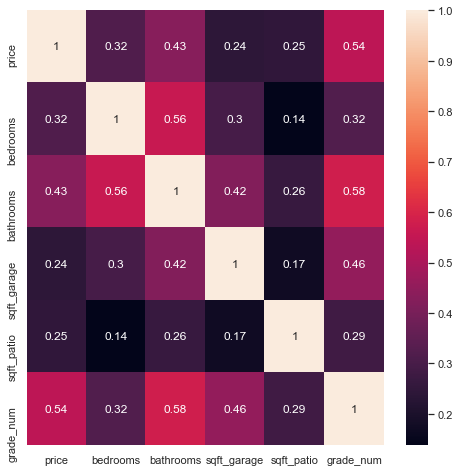

In [15]:
# Correlation heatmap to identify variable most correlated with price

fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(df_model_iqr.corr(), annot=True);

We can see that 'grade_num' has the highest correlation to 'price', followed by 'bathrooms'.

In [16]:
df_model_iqr.dtypes

price          float64
bedrooms         int64
bathrooms      float64
grade           object
sqft_garage      int64
sqft_patio       int64
grade_num        int64
dtype: object

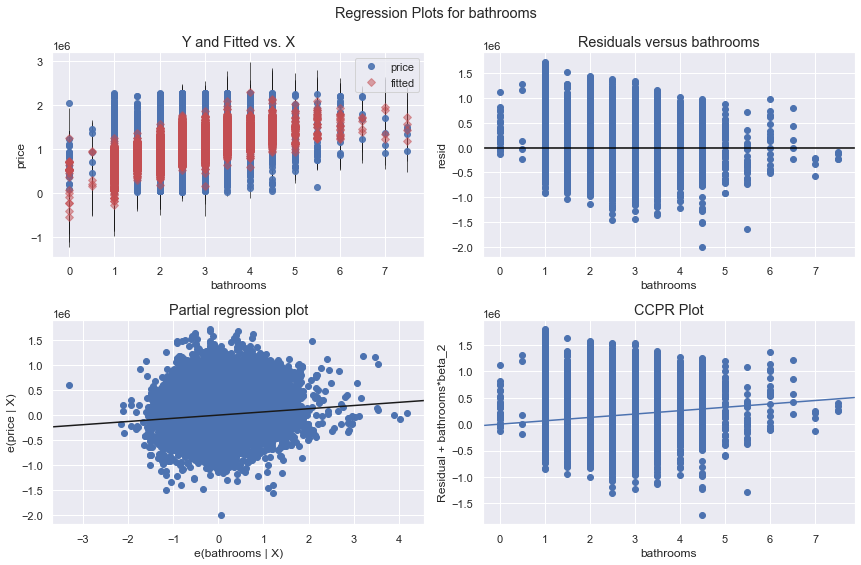

In [17]:
# Creating simple model with the most correlated variable

X = df_model_iqr.drop(['price', 'grade'], axis=1)
y = df_model_iqr['price']

first_model = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()
first_model.summary()

fig = plt.figure(figsize=(12,8))
sm.graphics.plot_regress_exog(first_model, 'bathrooms', fig=fig)
plt.show()

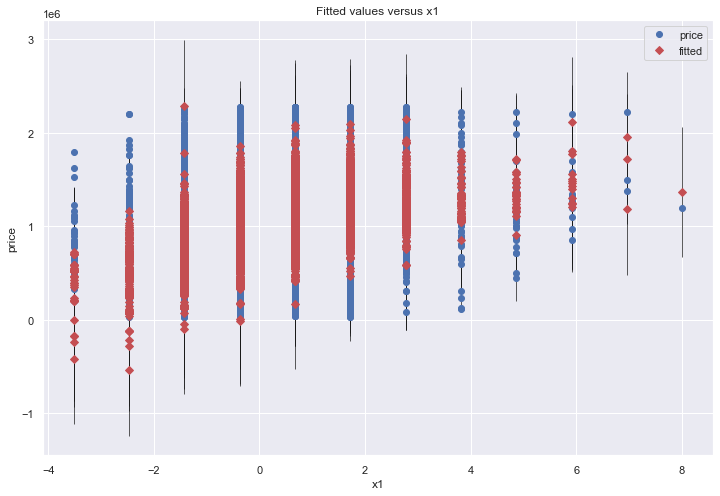

In [18]:
X = df_model_iqr.drop(['price', 'grade'], axis=1)
y = df_model_iqr['price']

# Normalize the data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the model with the normalized data
first_model_scaled = sm.OLS(endog=y, exog=sm.add_constant(X_scaled)).fit()
first_model_scaled.summary()

fig, ax = plt.subplots(figsize=(12,8))
sm.graphics.plot_fit(first_model_scaled, 1, ax=ax)
plt.show()

In [19]:
print(first_model_scaled)

Checking Residual Values

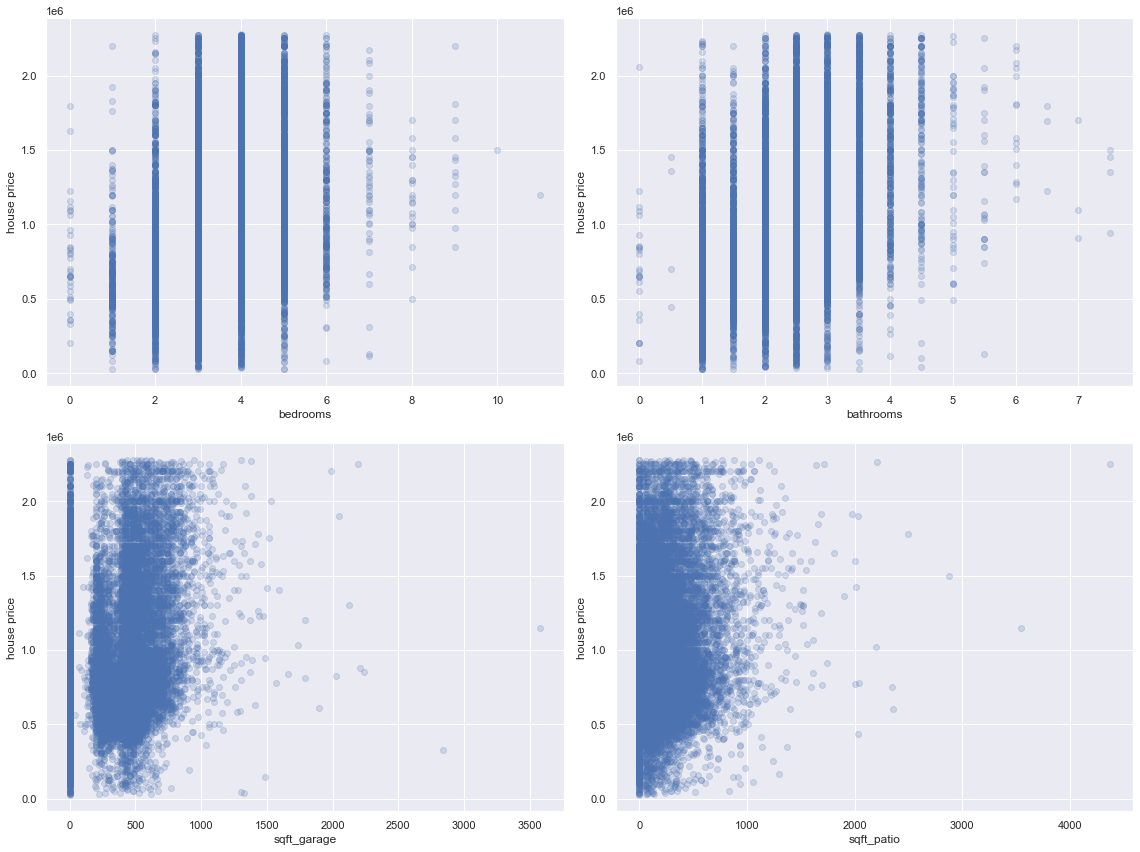

In [20]:
# Create scatter plots of remaining variables 

scatterplot_data = X_train.drop('grade_num', axis=1)

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 12))
fig.set_tight_layout(True)

for index, col in enumerate(scatterplot_data.columns):
    ax = axes[index//2][index%2]
    ax.scatter(X_train[col], y_train, alpha=0.2)
    ax.set_xlabel(col)
    ax.set_ylabel("house price")

## BUILDING MODEL WITH ALL FEATURES

In [21]:
# Create training model with all variables

all_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
all_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     2129.
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        18:07:16   Log-Likelihood:            -2.9990e+05
No. Observations:               21120   AIC:                         5.998e+05
Df Residuals:                   21114   BIC:                         5.999e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -8.296e+05   2.09e+04    -39.746      0.000   -8.71e+05   -7.89e+05
bedrooms     5.451e+04   3098.843     17.589      0.000    4.84e+04    6.06e+04
bathrooms    6.443e+04   4378.355     14.716      0.000    5.58e+04     7.3e+04
sqft_garage   -93.8720     10.354     -9.066      0.000    -114.167     -73.577
sqft_patio    154.8538     11.274     13.735      0.000     132.756     176.952
grade_num     1.92e+05   3157.516     60.812      0.000    1.86e+05    1.98e+05
==============================================================================
Omnibus:                     1511.160   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1951.954
Skew:                           0.652   Prob(JB):                         0.00
Kurtosis:                       3.719   Cond. No.                     4.02e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

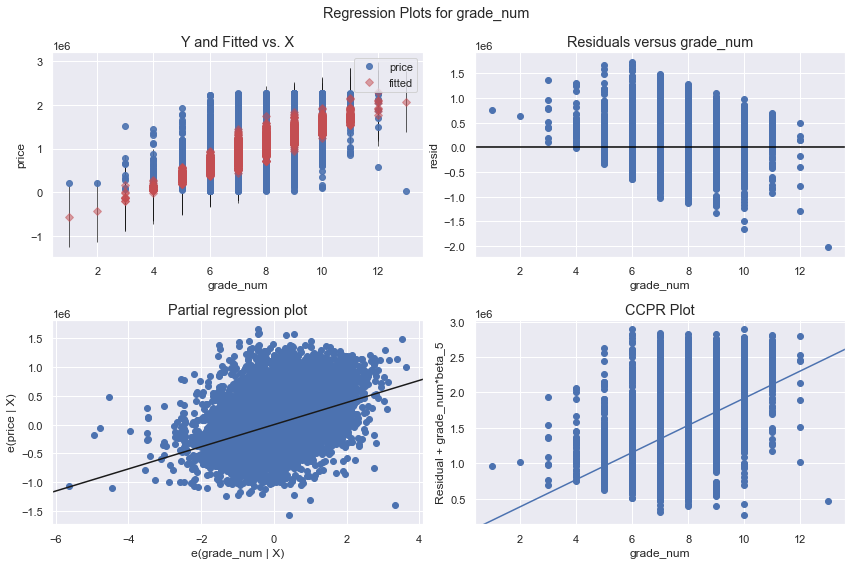

In [22]:
import statsmodels.graphics.regressionplots as smg

# Fit the model to the training data
all_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# Plot the regression line for the first predictor variable against the residual errors
fig = smg.plot_regress_exog(all_model, exog_idx=5, fig=plt.figure(figsize=(12, 8)))

## IDENTIFYING HOMEOWNER RENOVATION IMPACT ON PRICE

In [23]:
#Splitting data into combinations of garage and patio presence

no_garage_no_patio = df_model_iqr[(df_model_iqr['sqft_garage'] == 0) & (df_model_iqr['sqft_patio'] == 0)]
garage_no_patio = df_model_iqr[(df_model_iqr['sqft_garage'] > 0) & (df_model_iqr['sqft_patio'] == 0)]
no_garage_patio = df_model_iqr[(df_model_iqr['sqft_garage'] == 0) & (df_model_iqr['sqft_patio'] > 0)]
garage_patio = df_model_iqr[(df_model_iqr['sqft_garage'] > 0) & (df_model_iqr['sqft_patio'] > 0)]


In [24]:
# Defining x and y to visualize garage and patio impact on price

x = ['Neither', 'Garage Only', 'Patio Only', 'Both']

y = np.array([no_garage_no_patio['price'].mean(), garage_no_patio['price'].mean(),
     no_garage_patio['price'].mean(), garage_patio['price'].mean()], dtype='f')

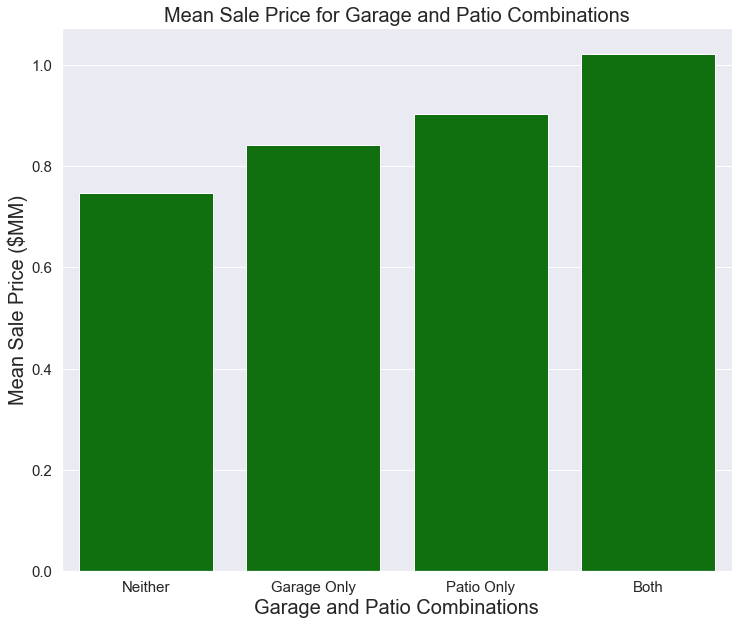

In [25]:
# Plotting garage and patio presence impact on mean price

fig, ax = plt.subplots(figsize = (12, 10))

y = y / 1000000

fig = sns.barplot(x = x,
                  y = y,
                  color='green')

plt.xlabel('Garage and Patio Combinations', size=20)
plt.xticks(fontsize=15)
plt.ylabel('Mean Sale Price ($MM)', size=20)
plt.yticks(fontsize=15)
plt.title('Mean Sale Price for Garage and Patio Combinations', size=20)
plt.show(fig);

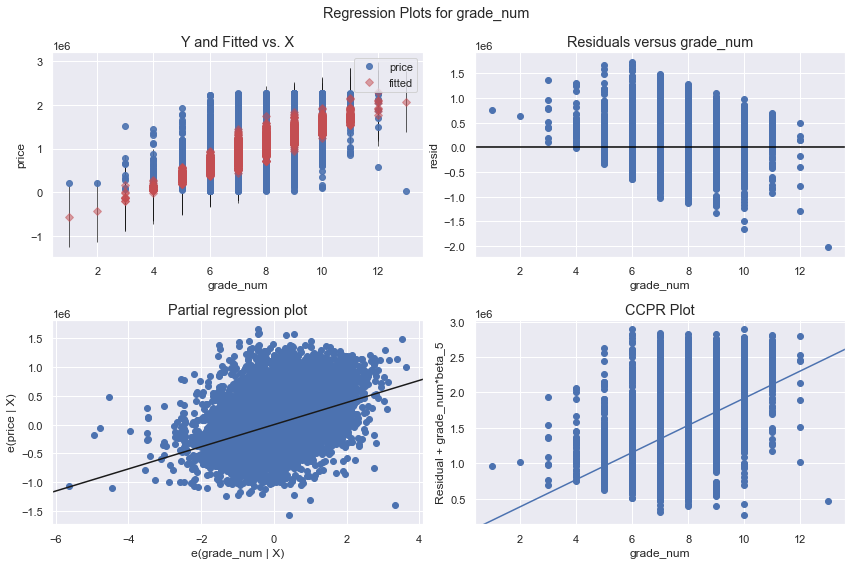

In [26]:


# Plot the regression line for the first predictor variable against the residual errors
fig = smg.plot_regress_exog(all_model, exog_idx=5, fig=plt.figure(figsize=(12, 8)))


In [27]:
df_model_iqr.head()

,price,bedrooms,bathrooms,grade,sqft_garage,sqft_patio,grade_num
0,675000.0,4,1.0,7 Average,0,40,7
1,920000.0,5,2.5,7 Average,0,240,7
2,311000.0,6,2.0,7 Average,0,0,7
3,775000.0,3,3.0,9 Better,200,270,9
4,592500.0,2,2.0,7 Average,550,30,7


In [28]:
df_model_iqr[['price','bathrooms']].sort_values('bathrooms',ascending=False)

,price,bathrooms
657,1450000.0,7.5
25484,1500000.0,7.5
21623,1350000.0,7.5
7950,945000.0,7.5
1949,1100000.0,7.0
...,...,...
28816,205000.0,0.0
1952,399990.0,0.0
7545,1225000.0,0.0
8338,550000.0,0.0


In [29]:
bathrooms = [3.0, 3.5, 4.0]
result = df.loc[df['bathrooms'].isin(bathrooms), ['price', 'bathrooms']]
result.sort_values('price', ascending=False)

,price,bathrooms
23470,30750000.0,3.5
8054,14850000.0,3.5
11464,11400000.0,3.5
24262,11300000.0,3.5
21840,10750000.0,3.5
...,...,...
23060,72500.0,3.0
4487,47801.0,3.0
12688,45000.0,3.0
17641,38478.0,3.0


## CALCULATE PRICE DIFFERENCE WITH BATHROOMS

In [30]:
bath_dummies = pd.get_dummies(df_model_iqr['bathrooms'], prefix='bath')
df_model_iqr_bath = pd.concat([df_model_iqr, bath_dummies], axis=1)
df_model_iqr_bath

,price,bedrooms,bathrooms,grade,sqft_garage,sqft_patio,grade_num,bath_0.0,bath_0.5,bath_1.0,...,bath_3.0,bath_3.5,bath_4.0,bath_4.5,bath_5.0,bath_5.5,bath_6.0,bath_6.5,bath_7.0,bath_7.5
0,675000.0,4,1.0,7 Average,0,40,7,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,920000.0,5,2.5,7 Average,0,240,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,311000.0,6,2.0,7 Average,0,0,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,775000.0,3,3.0,9 Better,200,270,9,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,592500.0,2,2.0,7 Average,550,30,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,1555000.0,5,2.0,8 Good,0,210,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30151,1313000.0,3,2.0,7 Average,0,520,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30152,800000.0,3,2.0,7 Average,240,110,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30153,775000.0,3,2.5,8 Good,480,100,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# Only the price and new bathroom columns
df_regr = df_model_iqr_bath[['price', 'bath_0.5','bath_1.5', 'bath_2.5', 'bath_3.5', 'bath_4.0', 'bath_5.5',]]
df_regr = sm.add_constant(df_regr)

# Fit the linear regression model
model = sm.OLS(df_regr['price'], df_regr.drop('price', axis=1)).fit()

# Print the regression summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     495.1
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        18:07:18   Log-Likelihood:            -4.0416e+05
No. Observations:               28161   AIC:                         8.083e+05
Df Residuals:                   28154   BIC:                         8.084e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        8.77e+05   3277.417    267.580      0.0

In [32]:
# Only the price and new bathroom columns
df_regr = df_model_iqr_bath[['price', 'bath_1.0', 'bath_1.5', 'bath_2.0', 'bath_2.5', 'bath_3.5', 'bath_4.0', 'bath_4.5', 'bath_5.0']]
df_regr = sm.add_constant(df_regr)

# Fit the linear regression model
model = sm.OLS(df_regr['price'], df_regr.drop('price', axis=1)).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     840.9
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        18:07:18   Log-Likelihood:            -4.0255e+05
No. Observations:               28161   AIC:                         8.051e+05
Df Residuals:                   28152   BIC:                         8.052e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.119e+06   6230.033    179.612      0.0

-131,000
116,100
425,100
629,900
422,800

247,100


1,119,000


Each one-unit increase in homes with 1 bathrooms is associated with a decrease in price of approximately $491,000.

The coefficient for for homes with 2 and half bathrooms is a one-unit increase in bath_2.5 is associated with a decrease in price of approximately $164,000.

On the other hand, for homes with 3 and a half bathrooms is associated with an increase in price of approximately $145,000.

To renovate a home with 1 bathroom to a 1 and half bath increases price by $80,000. 

To renovate a home with 1 and half bath to 2 bath increases price by $99,000.

To renovate a home with 1 bath to a 1 and half bath increases price by $148,100. 

4 bath to 4.5 bath = 93,300

1 bath to 2 bath = 178,900

1.5 bath to 2.5 bath = 247,100

4 bath to 5 bath = 23,000


Approximate average increase in price when renovating in bathrooms:

Adding a full bath, 150,000 - 200,000 in value. 

Adding a half bath, approximately 100,000 in value. 


In [45]:
df_price_bath = df_model_iqr[['price', 'bathrooms']]
df_price_bath

,price,bathrooms
0,675000.0,1.0
1,920000.0,2.5
2,311000.0,2.0
3,775000.0,3.0
4,592500.0,2.0
...,...,...
30150,1555000.0,2.0
30151,1313000.0,2.0
30152,800000.0,2.0
30153,775000.0,2.5


In [57]:
df_less_bathrooms = df_price_bath[df_price_bath['bathrooms'] <= 2]
df_more_bathrooms = df_price_bath[df_price_bath['bathrooms'] >= 2.5]


In [58]:
avg_price_less_bathrooms = df_less_bathrooms['price'].mean()
avg_price_more_bathrooms = df_more_bathrooms['price'].mean()


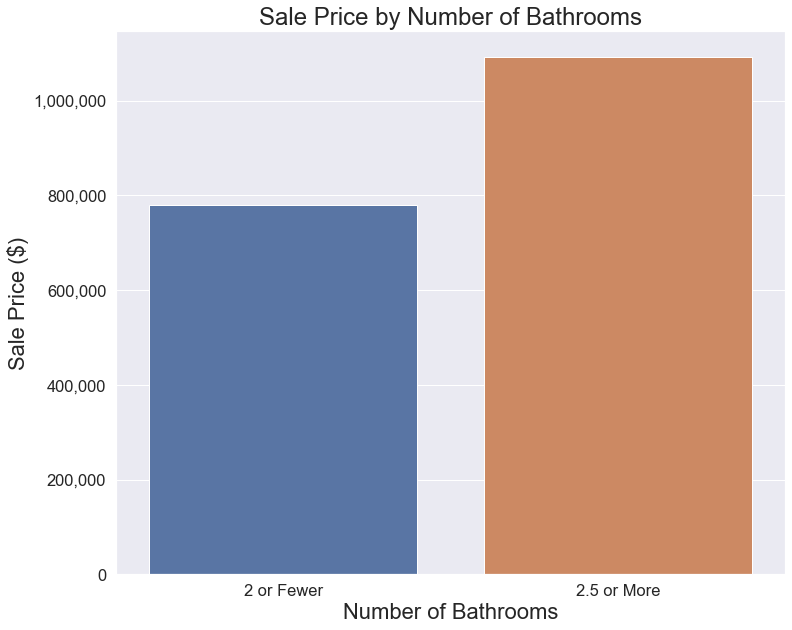

In [80]:
import matplotlib.ticker as ticker

# format for commas in y-axis
def format_price(x, pos):
    return '{:,.0f}'.format(x)

fig, ax = plt.subplots(figsize = (12 , 10))

sns.barplot(x=['2 or Fewer', '2.5 or More'], y=[avg_price_less_bathrooms, avg_price_more_bathrooms])
plt.title('Sale Price by Number of Bathrooms', size=24)
plt.xlabel('Number of Bathrooms', size=22)
plt.ylabel('Sale Price ($)', size=22)
plt.ticklabel_format(style='plain', axis='y')

formatter = ticker.FuncFormatter(format_price)
plt.gca().yaxis.set_major_formatter(formatter)

# Show the plot
plt.show()


In [86]:
df_price_bath['bathrooms'].value_counts()

2.5    8173
2.0    7237
1.0    4527
3.0    3836
1.5    1784
3.5    1774
4.0     464
4.5     216
5.0      52
5.5      31
0.0      30
6.0      19
6.5       5
0.5       5
7.0       4
7.5       4
Name: bathrooms, dtype: int64

In [46]:
price_2 = df_price_bath[df_price_bath['bathrooms'] == 2.0]['price'].mean()
price_2_5 = df_price_bath[df_price_bath['bathrooms'] == 2.5]['price'].mean()
price_diff = price_2_5 - price_2
print("Price difference between 2.0 and 2.5 bathrooms:", price_diff)


Price difference between 2.0 and 2.5 bathrooms: 148152.3255066726


In [85]:
mean_price_by_bath = df_model_iqr_bath.groupby('bathrooms')['price'].mean()
price_diff_by_bath = mean_price_by_bath.diff()
price_diff_dict = list(zip(df_model_iqr_bath.columns[7:], price_diff_by_bath.values))
price_diff_dict


[('bath_0.0', nan),
 ('bath_0.5', 252060.33333333337),
 ('bath_1.0', -304214.0072895958),
 ('bath_1.5', 79874.59529408009),
 ('bath_2.0', 98996.81865573407),
 ('bath_2.5', 148152.3255066726),
 ('bath_3.0', 116481.45344311954),
 ('bath_3.5', 192472.8842885238),
 ('bath_4.0', 111495.83527387935),
 ('bath_4.5', 93301.7013090679),
 ('bath_5.0', -116226.87571225083),
 ('bath_5.5', -90817.21464019851),
 ('bath_6.0', 373429.3786078098),
 ('bath_6.5', 139653.10526315798),
 ('bath_7.0', -549490.0),
 ('bath_7.5', 40750.0)]

In [51]:
for i in range(1, int(df_model_iqr_bath['bathrooms'].max())):
    if (i in df_model_iqr_bath['bathrooms'].values) and ((i+1) in df_model_iqr_bath['bathrooms'].values):
        price_i = df_model_iqr_bath[df_model_iqr_bath['bath_{}.0'.format(i)] == 1]['price'].mean()
        price_i_plus_1 = df_model_iqr_bath[df_model_iqr_bath['bath_{}.0'.format(i+1)] == 1]['price'].mean()
        price_diff = price_i_plus_1 - price_i
        print('Price difference between bath_{:.1f} and bath_{:.1f}: ${:,.2f}'.format(i, i+1, price_diff))


Price difference between bath_1.0 and bath_2.0: $178,871.41
Price difference between bath_2.0 and bath_3.0: $264,633.78
Price difference between bath_3.0 and bath_4.0: $303,968.72
Price difference between bath_4.0 and bath_5.0: $-22,925.17
Price difference between bath_5.0 and bath_6.0: $282,612.16
Price difference between bath_6.0 and bath_7.0: $-409,836.89


In [43]:
# Create new column for the price difference
df_model_iqr_bath['bath_2.5_minus_2.0'] = df_model_iqr_bath['bath_2.5'] - df_model_iqr_bath['bath_2.0']

# Compute the mean price for the rows where the difference is equal to 1
price_diff = df_model_iqr_bath[df_model_iqr_bath['bath_2.5_minus_2.0'] == 1]['price'].mean()

# Print the result
print("The average price difference between bath_2.0 and bath_2.5 is:", price_diff)


The average price difference between bath_2.0 and bath_2.5 is: 1000199.732166891


In [35]:
df_model_iqr_bath.corr()

,price,bedrooms,bathrooms,sqft_garage,sqft_patio,grade_num,bath_0.0,bath_0.5,bath_1.0,bath_1.5,...,bath_3.0,bath_3.5,bath_4.0,bath_4.5,bath_5.0,bath_5.5,bath_6.0,bath_6.5,bath_7.0,bath_7.5
price,1.000000,0.316549,0.433948,0.238916,0.245572,0.539910,-0.016237,0.001098,-0.270099,-0.112732,...,0.159914,0.219172,0.142591,0.115718,0.045116,0.027889,0.044141,0.026918,0.009015,0.010132
bedrooms,0.316549,1.000000,0.558958,0.296896,0.137610,0.322508,-0.100060,-0.010583,-0.371910,-0.105654,...,0.283536,0.171151,0.177633,0.131186,0.092180,0.063833,0.090540,0.034091,0.048596,0.061083
bathrooms,0.433948,0.558958,1.000000,0.422365,0.264228,0.581847,-0.091982,-0.029185,-0.684249,-0.243632,...,0.374500,0.406999,0.284272,0.248184,0.148368,0.135316,0.122195,0.071020,0.070989,0.078458
sqft_garage,0.238916,0.296896,0.422365,1.000000,0.172210,0.456079,-0.024517,-0.001782,-0.330568,-0.095745,...,0.133274,0.130860,0.053136,0.075102,0.041505,0.038285,-0.005353,0.012118,-0.002710,0.014253
sqft_patio,0.245572,0.137610,0.264228,0.172210,1.000000,0.285214,-0.018376,0.001366,-0.197645,-0.069743,...,0.111018,0.105562,0.069349,0.076069,0.024217,0.028422,0.018973,0.007264,0.003292,-0.008069
grade_num,0.539910,0.322508,0.581847,0.456079,0.285214,1.000000,-0.039531,-0.020112,-0.463272,-0.116098,...,0.135507,0.255659,0.116616,0.127944,0.047934,0.057607,0.023431,0.017046,0.008718,-0.000184
bath_0.0,-0.016237,-0.100060,-0.091982,-0.024517,-0.018376,-0.039531,1.000000,-0.000435,-0.014292,-0.008493,...,-0.012968,-0.008467,-0.004227,-0.002871,-0.001405,-0.001084,-0.000849,-0.000435,-0.000389,-0.000389
bath_0.5,0.001098,-0.010583,-0.029185,-0.001782,0.001366,-0.020112,-0.000435,1.000000,-0.005832,-0.003466,...,-0.005292,-0.003455,-0.001725,-0.001172,-0.000573,-0.000442,-0.000346,-0.000178,-0.000159,-0.000159
bath_1.0,-0.270099,-0.371910,-0.684249,-0.330568,-0.197645,-0.463272,-0.014292,-0.005832,1.000000,-0.113821,...,-0.173800,-0.113480,-0.056647,-0.038478,-0.018824,-0.014529,-0.011372,-0.005832,-0.005216,-0.005216
bath_1.5,-0.112732,-0.105654,-0.243632,-0.095745,-0.069743,-0.116098,-0.008493,-0.003466,-0.113821,1.000000,...,-0.103276,-0.067432,-0.033661,-0.022864,-0.011186,-0.008633,-0.006757,-0.003466,-0.003100,-0.003100


In [ ]:
# Create a new column indicating whether there has been a bedroom renovation
df_model_iqr_bath['renovated_bathrooms'] = df_model_iqr_bath['bathrooms'].apply(lambda x: 'Renovated' if x > 2 else 'Not Renovated')

# Group the data by the renovated_bedroom column and calculate the mean price for each group
renovated_bathrooms_mean_price = df_model_iqr_bath.groupby('renovated_bathrooms')['price'].mean()

# Print the result
print(renovated_bathrooms_mean_price)



In [ ]:
import matplotlib.ticker as ticker

# Define the formatter function
def format_price(x, pos):
    return '{:,.0f}'.format(x)

# Create the scatter plot
sns.barplot(data=df_model_iqr_bath, x='renovated_bathrooms', y='price',hue_order=['Renovated', 'Not Renovated'])

# Set the plot labels and title
plt.xlabel('Renovated Bathrooms')
plt.ylabel('Mean Price')
plt.title('Mean Price by Renovated Bathrooms')
plt.ticklabel_format(style='plain', axis='y')

# Format the y-axis tick labels with commas as thousand separators
formatter = ticker.FuncFormatter(format_price)
plt.gca().yaxis.set_major_formatter(formatter)

# Show the plot
plt.show()


## CALCULATE PRICE DIFFERENCE WITH BEDROOM RENOVATIONS

In [ ]:
bed_dummies = pd.get_dummies(df_model_iqr['bedrooms'], prefix='bed')
df_model_iqr_bed = pd.concat([df_model_iqr, bed_dummies], axis=1)
df_model_iqr_bed

In [ ]:
bed_correlations = df_model_iqr_bed[['price', 'bed_3', 'bed_4', 'bed_5', 'bed_6', 'bed_7']]

bed_correlations = sm.add_constant(bed_correlations)

# Fit the linear regression model
model = sm.OLS(bed_correlations['price'], bed_correlations.drop('price', axis=1)).fit()

# Print the regression summary
print(model.summary())


3 and 4 = 208,000
4 and 5 = 97,000
5 and 6 = 38,000
6 and 7 = 79,000

Approximate increase in price when renovating bedrooms: $105,000

In [ ]:
df_model_iqr_bed.corr()

In [ ]:
# Create a new column indicating whether there has been a bedroom renovation
df_model_iqr_bed['renovated_bedroom'] = df_model_iqr_bed['bedrooms'].apply(lambda x: 'Renovated' if x > 2 else 'Not Renovated')

# Group the data by the renovated_bedroom column and calculate the mean price for each group
renovated_bedroom_mean_price = df_model_iqr_bed.groupby('renovated_bedroom')['price'].mean()

# Print the result
print(renovated_bedroom_mean_price)



In [ ]:
# Create a scatter plot
sns.barplot(data=df_model_iqr_bed, x='renovated_bedroom', y='price', hue_order=['Renovated', 'Not Renovated'])

# Set the plot labels and title
plt.xlabel('Renovated Bedrooms')
plt.ylabel('Mean Price')
plt.title('Mean Price by Renovated Bedrooms')

# Show the plot
plt.show()
